In [108]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

np.set_printoptions(precision=3, suppress=True)
np.set_printoptions(legacy='1.13')

beta, alpha = 2,1.5
N = 20 #number of product

## 🧪 Practice 2: Log-Inversion of Market Shares

### 🎯 Goal
Recover mean utility $\delta_j$ from observed market shares under the logit model.

### 💡 Formula
From the logit structure:

$$
\delta_j = \log(s_j) - \log(s_0)
$$

### ✅ What You Did
- Simulated $\delta_j$, computed $s_j$
- Inverted $s_j$ to get back $\delta_j^{\text{inv}}$
- Verified recovery by plotting: true $\delta_j$ vs. inverted $\delta_j$

### 📈 Result
Points lie on the 45° line — inversion works!

This step builds the core intuition for the BLP inner loop.

In [109]:
# Building the model: basic definitions 

def mean_utility(beta, alpha, N): #one mean utility 
    x = np.random.normal(0,1, N)
    p = np.random.uniform(1,5, N)
    return x*beta - alpha*p

def market_share(delta_array):
    no_product = len(delta_array)
    output = np.zeros(no_product+1)
    denom = 1 + sum([np.exp(i) for i in delta_array])
    for i in range(no_product):
        output[i] = np.exp(delta_array[i])/denom
    output[-1] = 1 - sum(output)
    return output


[-7.493 -4.169 -9.355 -5.652 -2.692 -4.66  -2.373 -5.599 -5.424 -5.549
 -4.986 -7.541  0.013 -6.396 -6.906 -5.477 -3.036 -5.706 -3.002 -5.919]
[ 0.     0.007  0.     0.002  0.029  0.004  0.04   0.002  0.002  0.002
  0.003  0.     0.434  0.001  0.     0.002  0.021  0.001  0.021  0.001
  0.429]


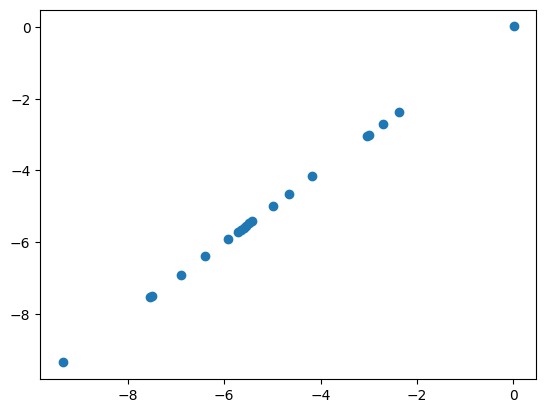

In [110]:
mean_delta = mean_utility(beta,alpha,N)
share = market_share(mean_delta)
print(mean_delta)
print(share)
# now we have arrived at the market share 
inverted_delta = []
for i in range(len(share)-1):
    inverted_delta.append(np.log(share[i]) - np.log(share[-1]))

plt.scatter(mean_delta, inverted_delta)
plt.show()

## 🧪 Practice 3: Simulating Multiple Markets

### 🎯 Goal
Simulate product-level data across multiple markets to create a panel dataset of prices, characteristics, utilities, and shares. This mirrors real-world data structure and prepares for estimation.

---

### ⚙️ Setup

- Simulate $T$ markets (e.g., $T = 50$), each with $J$ products (e.g., $J = 5$)
- For each product $j$ in market $t$:
  - Draw $x_{jt} \sim \mathcal{N}(0, 1)$ (product characteristic)
  - Draw $p_{jt} \sim \mathcal{U}(1, 5)$ (price)
  - Compute utility: $\delta_{jt} = x_{jt} \cdot \beta - \alpha \cdot p_{jt}$
  - Compute share: 
    $$
    s_{jt} = \frac{e^{\delta_{jt}}}{1 + \sum_k e^{\delta_{kt}}}, \quad
    s_{0t} = \frac{1}{1 + \sum_k e^{\delta_{kt}}}
    $$

---

### ✅ Tasks

- Simulate and store data for each market-product pair:
  - `market_id`, `product_id`, `x`, `p`, `delta`, `share`, `s0`
- Optional: visualize share distributions or trends across markets

---

### 📌 Purpose
Build the panel structure needed for:
- Demand estimation using variation across markets
- Adding heterogeneity in consumer preferences (next step in BLP)

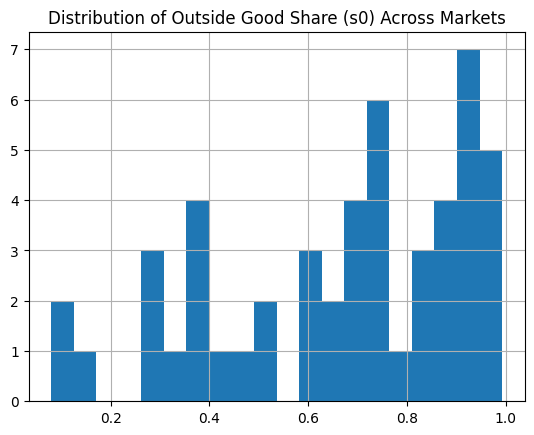

In [111]:
T = 50 #number of markets 
J = 5 #number of products 
all_markets = []

# Practice 3: Simulating multiple markets 
# creating the dataset for later estimation 

for i in range(T): #over each market 
    x = np.random.normal(0,1, J)
    p = np.random.uniform(1,5, J)
    delta = x * beta - alpha * p 
    share = market_share(delta)
    market_data = pd.DataFrame({
        'market_id': [i] * J,
        'product_id': list(range(J)),
        'x': x,
        'p': p,
        'delta': delta,
        'share': share[:-1],
        's0': [share[-1]] * J})
    all_markets.append(market_data)


df_panel = pd.concat(all_markets, ignore_index=True)
# print(all_markets)

df_panel.groupby('market_id')['s0'].first().hist(bins=20)
plt.title("Distribution of Outside Good Share (s0) Across Markets")
plt.show()

df_panel.to_csv("multi_market_data.csv", index=False)